In [1]:
import os
from fastai.vision import *
from fastai.core import *
from pathlib import Path
from torchvision.models import vgg16_bn, resnet34
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch

print(torch.__version__)
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import os
from torch.optim import *
os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

1.3.1


In [2]:
x = "data"
path = Path(x)
path_hr = path / "train"
path_lr = path / "crappy"
# path_lr.mkdir(exist_ok=True)

In [3]:
global il
il = ImageList.from_folder(path_hr, recurse=True)
il.items

array([], dtype=object)

In [4]:
def crappy(path, size):
    img = PIL.Image.open(path)
    targ_sz = resize_to(img, size, use_min=True)
    y = (
        path_lr
        / Path(os.path.basename(os.path.dirname(path)))
        / Path(os.path.basename(path))
    )
    z = path_lr / Path(os.path.basename(os.path.dirname(path)))
    z.mkdir(exist_ok=True)
    q = random.randint(1, 25)
    img = (
        img.resize(targ_sz, resample=PIL.Image.BILINEAR)
        .convert("RGB")
        .save(fp=y, quality=q)
    )

In [11]:
# uncomment if you are running it for the first time to make a crappy phtoos
for i in range(len(il.items)):
    crappy(il.items[i], 256)

In [20]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct()
src

ItemLists;

Train: ImageImageList (75 items)
Image (3, 256, 380),Image (3, 342, 256),Image (3, 387, 255),Image (3, 379, 255),Image (3, 379, 255)
Path: data/crappy;

Valid: ImageImageList (18 items)
Image (3, 352, 256),Image (3, 341, 256),Image (3, 376, 255),Image (3, 330, 256),Image (3, 340, 256)
Path: data/crappy;

Test: None

In [21]:
def get_data(bs, size):
    data = (
        src.label_from_func(lambda x: path_hr / x.relative_to(path_lr))
        .transform(get_transforms(max_zoom=2.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True)
    )

    data.c = 3
    return data

In [23]:
data_gen = get_data(6, 256)

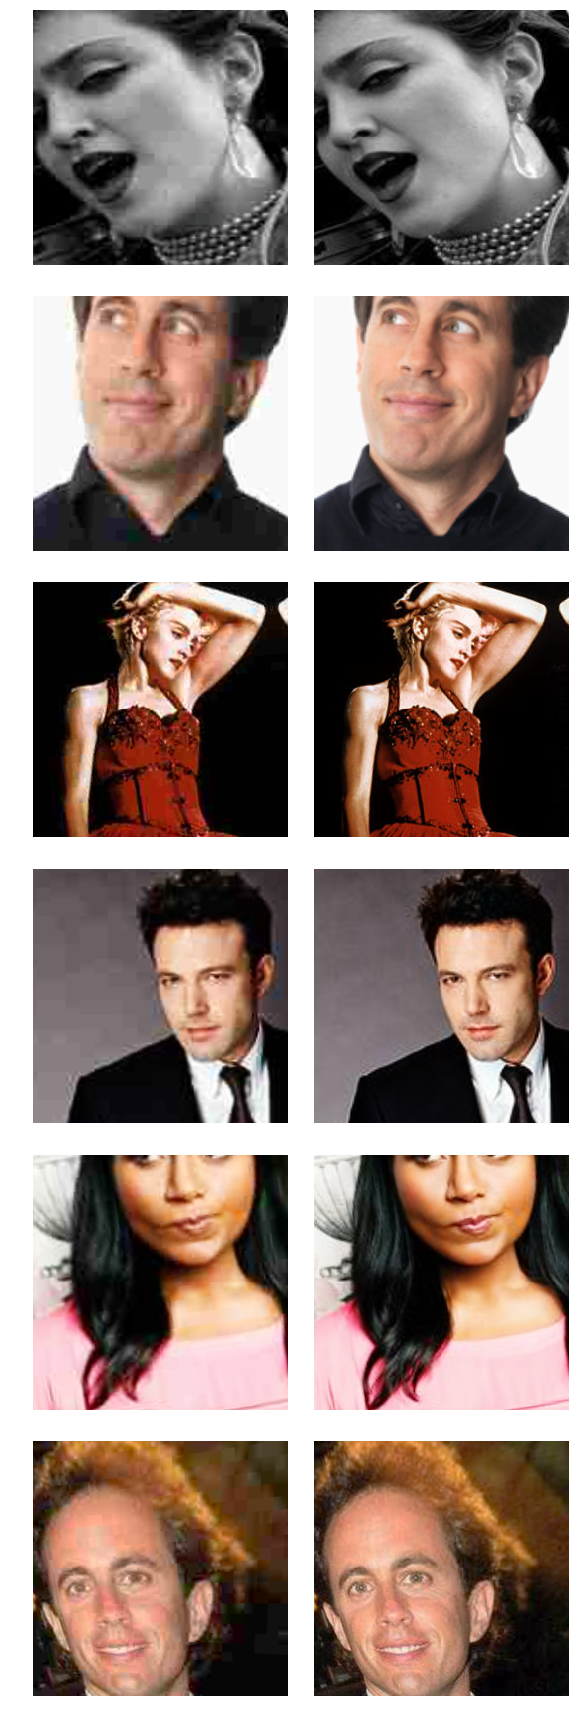

In [24]:
data_gen.show_batch(10)

In [25]:
loss_gen = MSELossFlat()
wd = 1e-3
y_range = (-3.0, 3.0)

In [26]:
# FEATURE LOSS FUNCTION
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2)) / (c * h * w)

In [29]:
vgg_m = vgg16_bn(
    True
).features  # this gives us the features of the VGG model.It is part of Pytorch Torchvision library
requires_grad(
    vgg_m, False
)  # this is set to false as we will not be updating the weights of this model

In [30]:
blocks = [i - 1 for i, o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [31]:
vgg_m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [32]:
base_loss = F.l1_loss

In [35]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = (
            ["pixel",]
            + [f"feat_{i}" for i in range(len(layer_ids))]
            + [f"gram_{i}" for i in range(len(layer_ids))]
        )

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [
            base_loss(f_in, f_out) * w
            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)
        ]
        self.feat_losses += [
            base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w ** 2 * 5e3
            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)
        ]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

    def __del__(self):
        self.hooks.remove()

In [40]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 15, 2]).to('cuda')
wd = 1e-3
arch = models.resnet34

In [41]:
learn = unet_learner(
    data_gen,
    arch,
    wd=wd,
    loss_func=feat_loss,
    callback_fns=LossMetrics,
    blur=True,
    norm_type=NormType.Weight,
).to_fp16()

In [46]:
gc.collect()
learn.unfreeze()
learn.fit_one_cycle(30, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.767620,3.636183,0.936970,0.327669,0.423395,0.230465,0.485587,0.869954,0.362143,00:05
1,3.728961,3.629701,0.942284,0.328972,0.425278,0.227306,0.481861,0.873246,0.350753,00:05
2,3.691023,3.642132,0.908110,0.327184,0.422909,0.240308,0.479876,0.869870,0.393876,00:05
3,3.672701,3.565404,0.842845,0.324348,0.419605,0.237311,0.484068,0.865603,0.391625,00:05
4,3.616958,3.440817,0.763013,0.319928,0.415154,0.232299,0.472053,0.857719,0.380650,00:05
5,3.545576,3.348681,0.684745,0.315333,0.409920,0.231944,0.464749,0.850830,0.391160,00:05
6,3.477958,3.153524,0.595380,0.309919,0.403936,0.210841,0.468864,0.834627,0.329958,00:05
7,3.436707,3.161077,0.608543,0.305122,0.397584,0.215293,0.470273,0.828533,0.335729,00:05
8,3.361676,3.082144,0.533171,0.302073,0.392247,0.217742,0.454673,0.809491,0.372747,00:05
9,3.299719,3.264689,0.663676,0.302528,0.395698,0.226118,0.463310,0.832550,0.380808,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


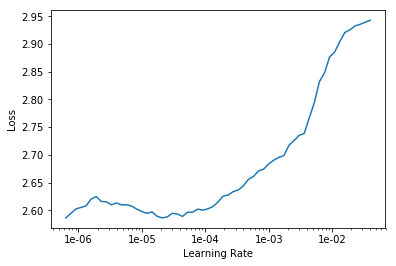

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.unfreeze()
learn.fit_one_cycle(30, slice(1e-6, 1e-5),wd = 10e-4)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.623232,2.679790,0.299599,0.290954,0.373233,0.202425,0.407508,0.767367,0.338704,00:05
1,2.617380,2.679271,0.299134,0.290893,0.373128,0.202521,0.407350,0.766748,0.339497,00:05
2,2.624238,2.681205,0.301514,0.290837,0.373261,0.202081,0.406974,0.768319,0.338219,00:05
3,2.605065,2.675786,0.298422,0.290390,0.372396,0.202064,0.407199,0.765197,0.340118,00:05
4,2.605813,2.680518,0.300408,0.290055,0.371895,0.203176,0.406016,0.763988,0.344981,00:05
5,2.604483,2.679838,0.300988,0.289819,0.371741,0.203294,0.404527,0.763500,0.345970,00:05
6,2.600646,2.657167,0.296541,0.289449,0.370828,0.199801,0.403473,0.761285,0.335790,00:05
7,2.598236,2.625623,0.297182,0.289153,0.370266,0.191289,0.403119,0.760444,0.314169,00:05
8,2.602880,2.619489,0.291639,0.288433,0.368992,0.193991,0.399800,0.757341,0.319293,00:05
9,2.598954,2.643006,0.294146,0.288582,0.369250,0.198856,0.398808,0.760267,0.333097,00:05


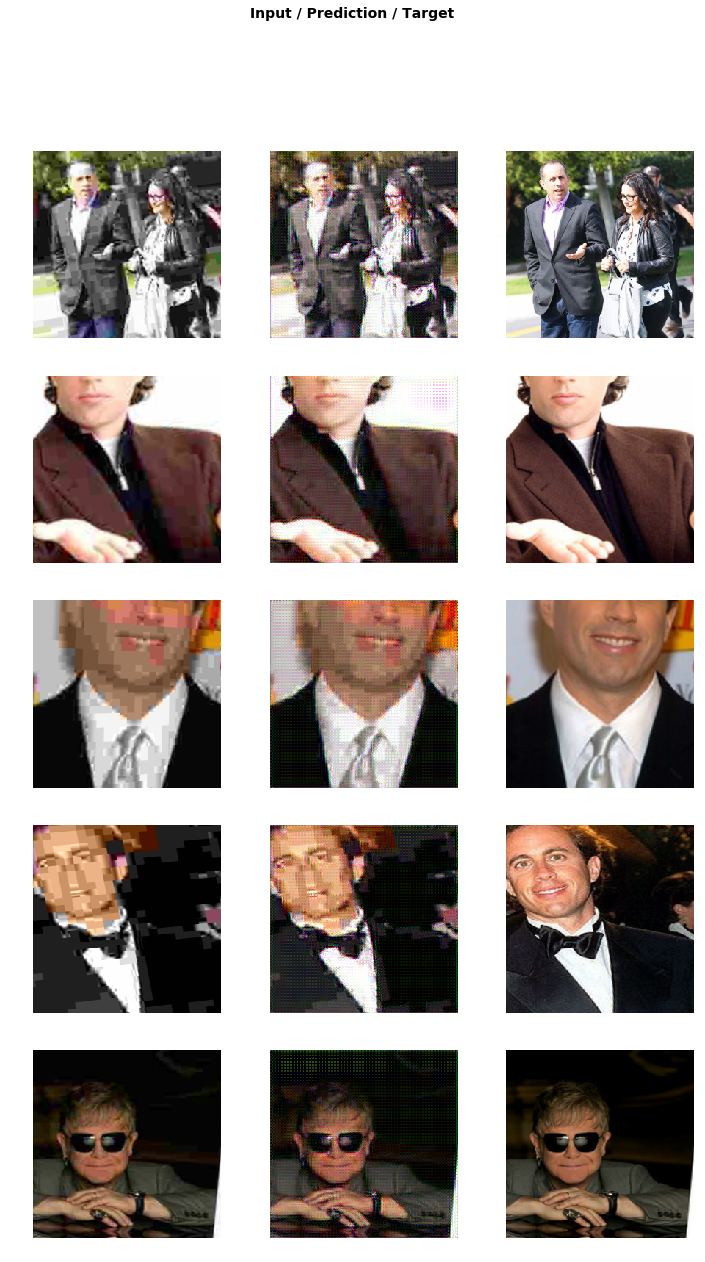

In [49]:
learn.show_results(ds_type=DatasetType.Train)